In [2]:
# %pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=95d475c75168d6c1161ac232d1ba9dc7d9d2c4d53be23910c43cedbcc4bfabcd
  Stored in directory: /Users/naveedfarooq/Library/Caches/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=419dbfbbf5719558575f3143d8f85622a9b7f7b34d686d8a3c889a128d27d60d
  Stored in 

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
adata1 = sc.read(r'dataset_extracted/GSM5201883/matrix.mtx.gz', cache=True).transpose()
adata1.var_names = pd.read_csv(r'dataset_extracted/GSM5201883/features.tsv.gz', header=None, sep='\t')[1]
adata1.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201883/barcodes.tsv.gz', header=None)[0])

In [64]:
adata1

AnnData object with n_obs × n_vars = 5538 × 33538

In [65]:
adata2 = sc.read(r'dataset_extracted/GSM5201884/matrix.mtx.gz', cache=True).transpose()
adata2.var_names = pd.read_csv(r'dataset_extracted/GSM5201884/features.tsv.gz', header=None, sep='\t')[1]
adata2.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201884/barcodes.tsv.gz', header=None)[0])

In [66]:
adata2

AnnData object with n_obs × n_vars = 10756 × 33538

In [67]:
adata3 = sc.read(r'dataset_extracted/GSM5201885/matrix.mtx.gz', cache=True).transpose()
adata3.var_names = pd.read_csv(r'dataset_extracted/GSM5201885/features.tsv.gz', header=None, sep='\t')[1]
adata3.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201885/barcodes.tsv.gz', header=None)[0])

In [68]:
adata3

AnnData object with n_obs × n_vars = 6753 × 33538

In [69]:
adata4 = sc.read(r'dataset_extracted/GSM5201886/matrix.mtx.gz', cache=True).transpose()
adata4.var_names = pd.read_csv(r'dataset_extracted/GSM5201886/features.tsv.gz', header=None, sep='\t')[1]
adata4.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201886/barcodes.tsv.gz', header=None)[0])

In [70]:
adata4

AnnData object with n_obs × n_vars = 9676 × 33538

In [71]:

# matrix file has row and column names, so remove them:
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
adata4.var_names_make_unique()

In [72]:
adata_list = [adata1, adata2, adata3, adata4]
adata_merged = ad.AnnData.concatenate(*adata_list, join='outer')


/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [73]:

adata_merged.obs_names = pd.concat([pd.Series(adata1.obs_names), 
                              pd.Series(adata2.obs_names), 
                              pd.Series(adata3.obs_names), 
                              pd.Series(adata4.obs_names)], join='outer')


In [74]:
adata_merged.var_names = adata1.var_names

In [75]:
adata_merged.obs_names_make_unique()


In [76]:
adata = adata_merged

In [77]:
adata.shape

(32723, 33538)

In [78]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 32723
Total number of genes: 33538


# DATA PREPROCESSING 

### Show those genes that yield the highest fraction of counts in each single cell, across all cells



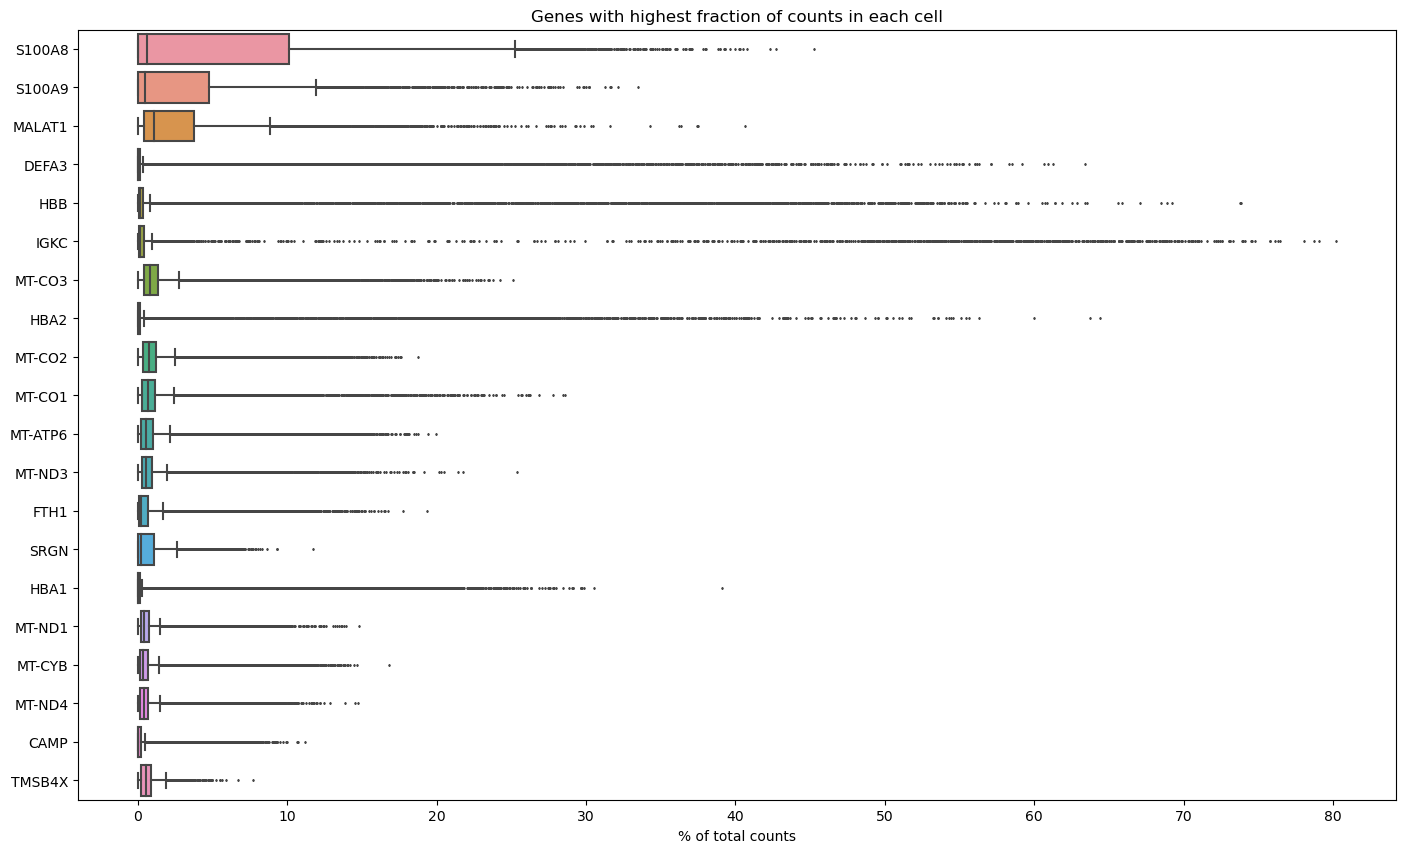

In [79]:
sc.pl.highest_expr_genes(adata, n_top=20, show=False)
fig = plt.gcf()
fig.set_size_inches(17, 10)

plt.title("Genes with highest fraction of counts in each cell")
plt.show()

### Filtering out cells that have less than 200 genes, and genes that are detected in less than 3 cells

In [80]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [81]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 31583
Total number of genes: 22589


In [82]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

In [83]:
# Scaling
# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)


In [23]:
# %pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.8 MB/s eta 0:00:0000:01:00:01
Note: you may need to restart the kernel to use updated packages.


### Identify highly-variable genes

In [84]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)


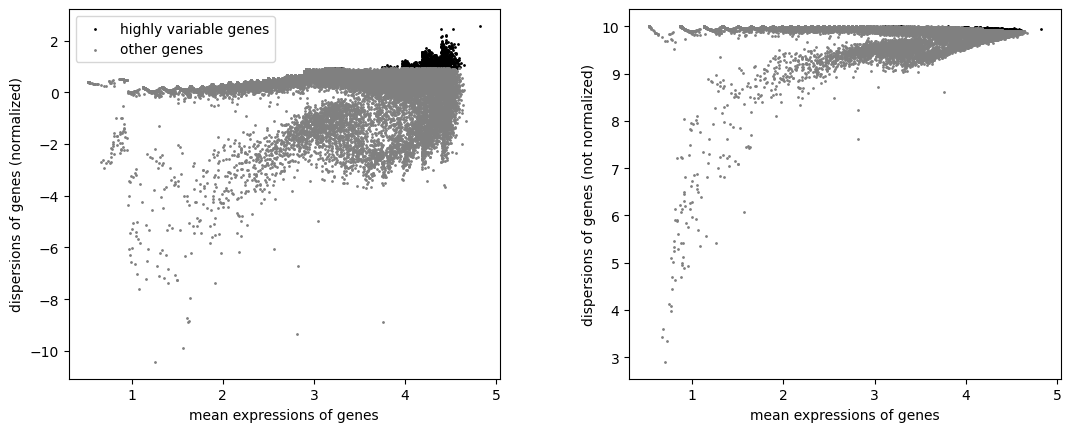

In [85]:
sc.pl.highly_variable_genes(adata)


In [91]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata


In [92]:
# Filtering:
adata = adata[:, adata.var.highly_variable]


# PRINCIPLE COMPONENT ANALYSIS

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [93]:
sc.tl.pca(adata, svd_solver='arpack')


In [94]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)


In [95]:
sc.tl.leiden(adata, resolution=0.5)


In [96]:
sc.tl.umap(adata)


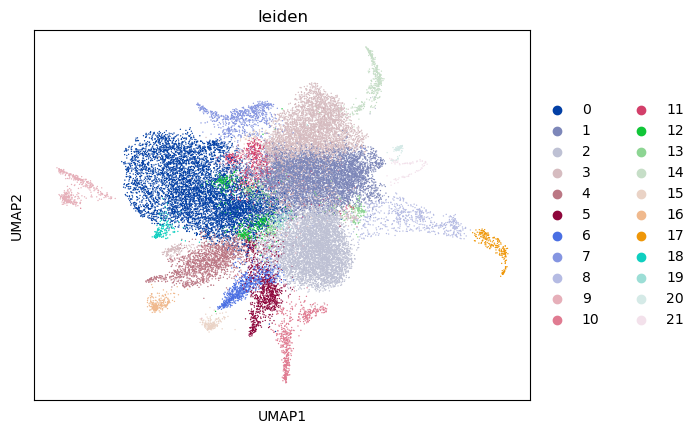

In [97]:
sc.pl.umap(adata, color=['leiden'], cmap='viridis')


## Scatter Plot

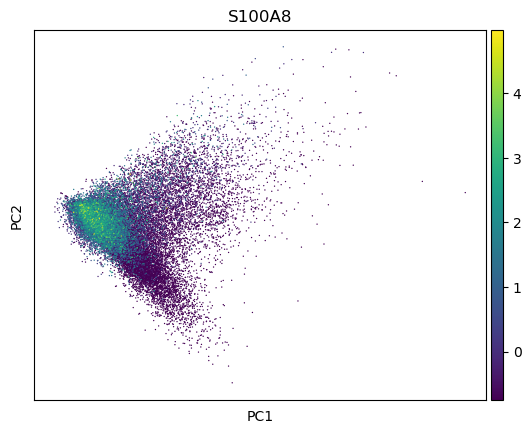

In [101]:
sc.pl.pca(adata, color='S100A8')


## Inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCAs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). (Often a rough estimate of the number of PCs works).

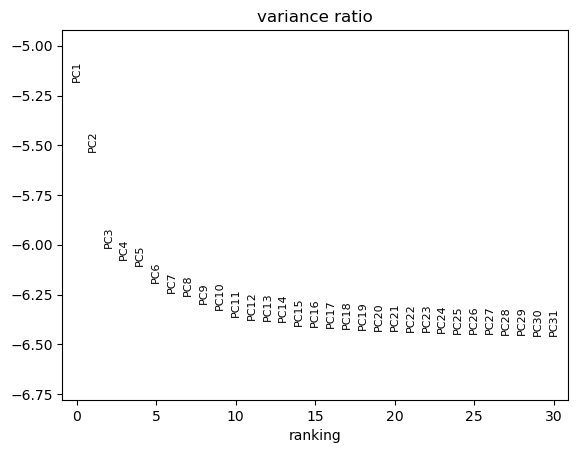

In [99]:
sc.pl.pca_variance_ratio(adata, log=True)


In [102]:
adata.write("results_file.h5ad")


In [ ]:
# adata

## Computing the Neighbourhood Graph

In [103]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)


## Embedding the neighborhood graph


Embedding the graph in two dimensions using UMAP (McInnes et al., 2018). 
It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [ ]:
# pip install leidenalg

In [104]:
sc.tl.leiden(adata)

In [105]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [106]:
sc.tl.umap(adata)


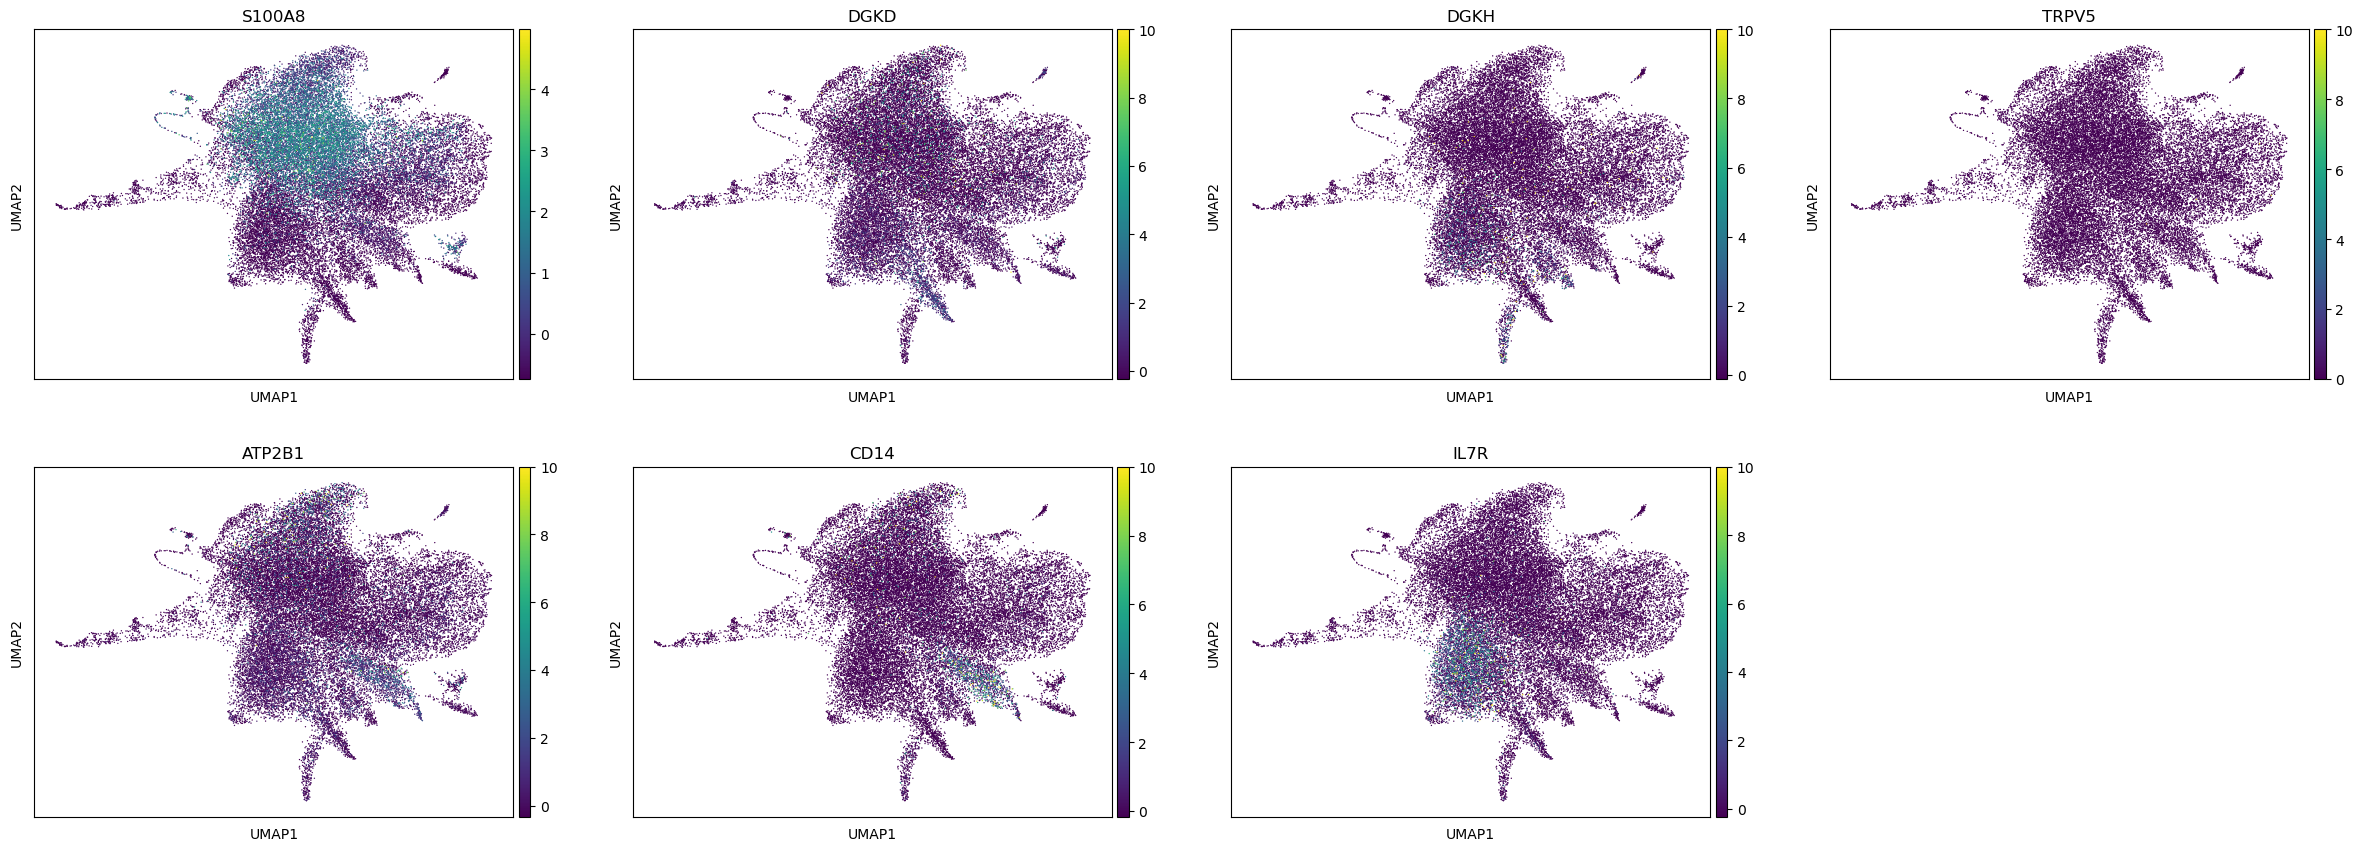

In [108]:
sc.pl.umap(adata, color=['S100A8','DGKD','DGKH','TRPV5', 'ATP2B1',
                        'CD14', 'IL7R'])


### Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.


In [109]:
sc.tl.leiden(adata)


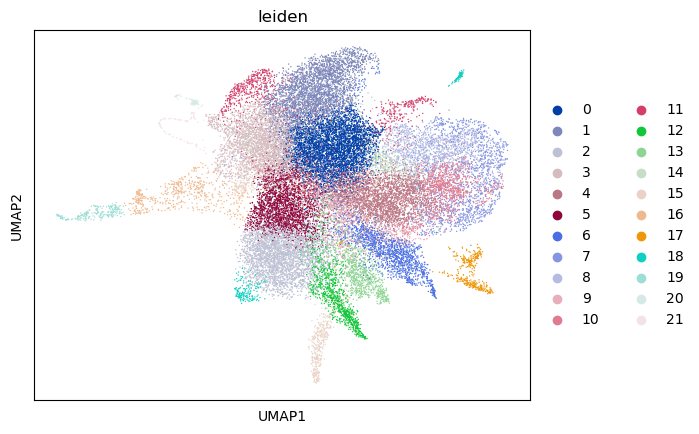

In [110]:
sc.pl.umap(adata, color=['leiden'])


In [111]:
adata.write("results_file.h5ad")


## Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the **t-test**.

/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/naveedfarooq/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

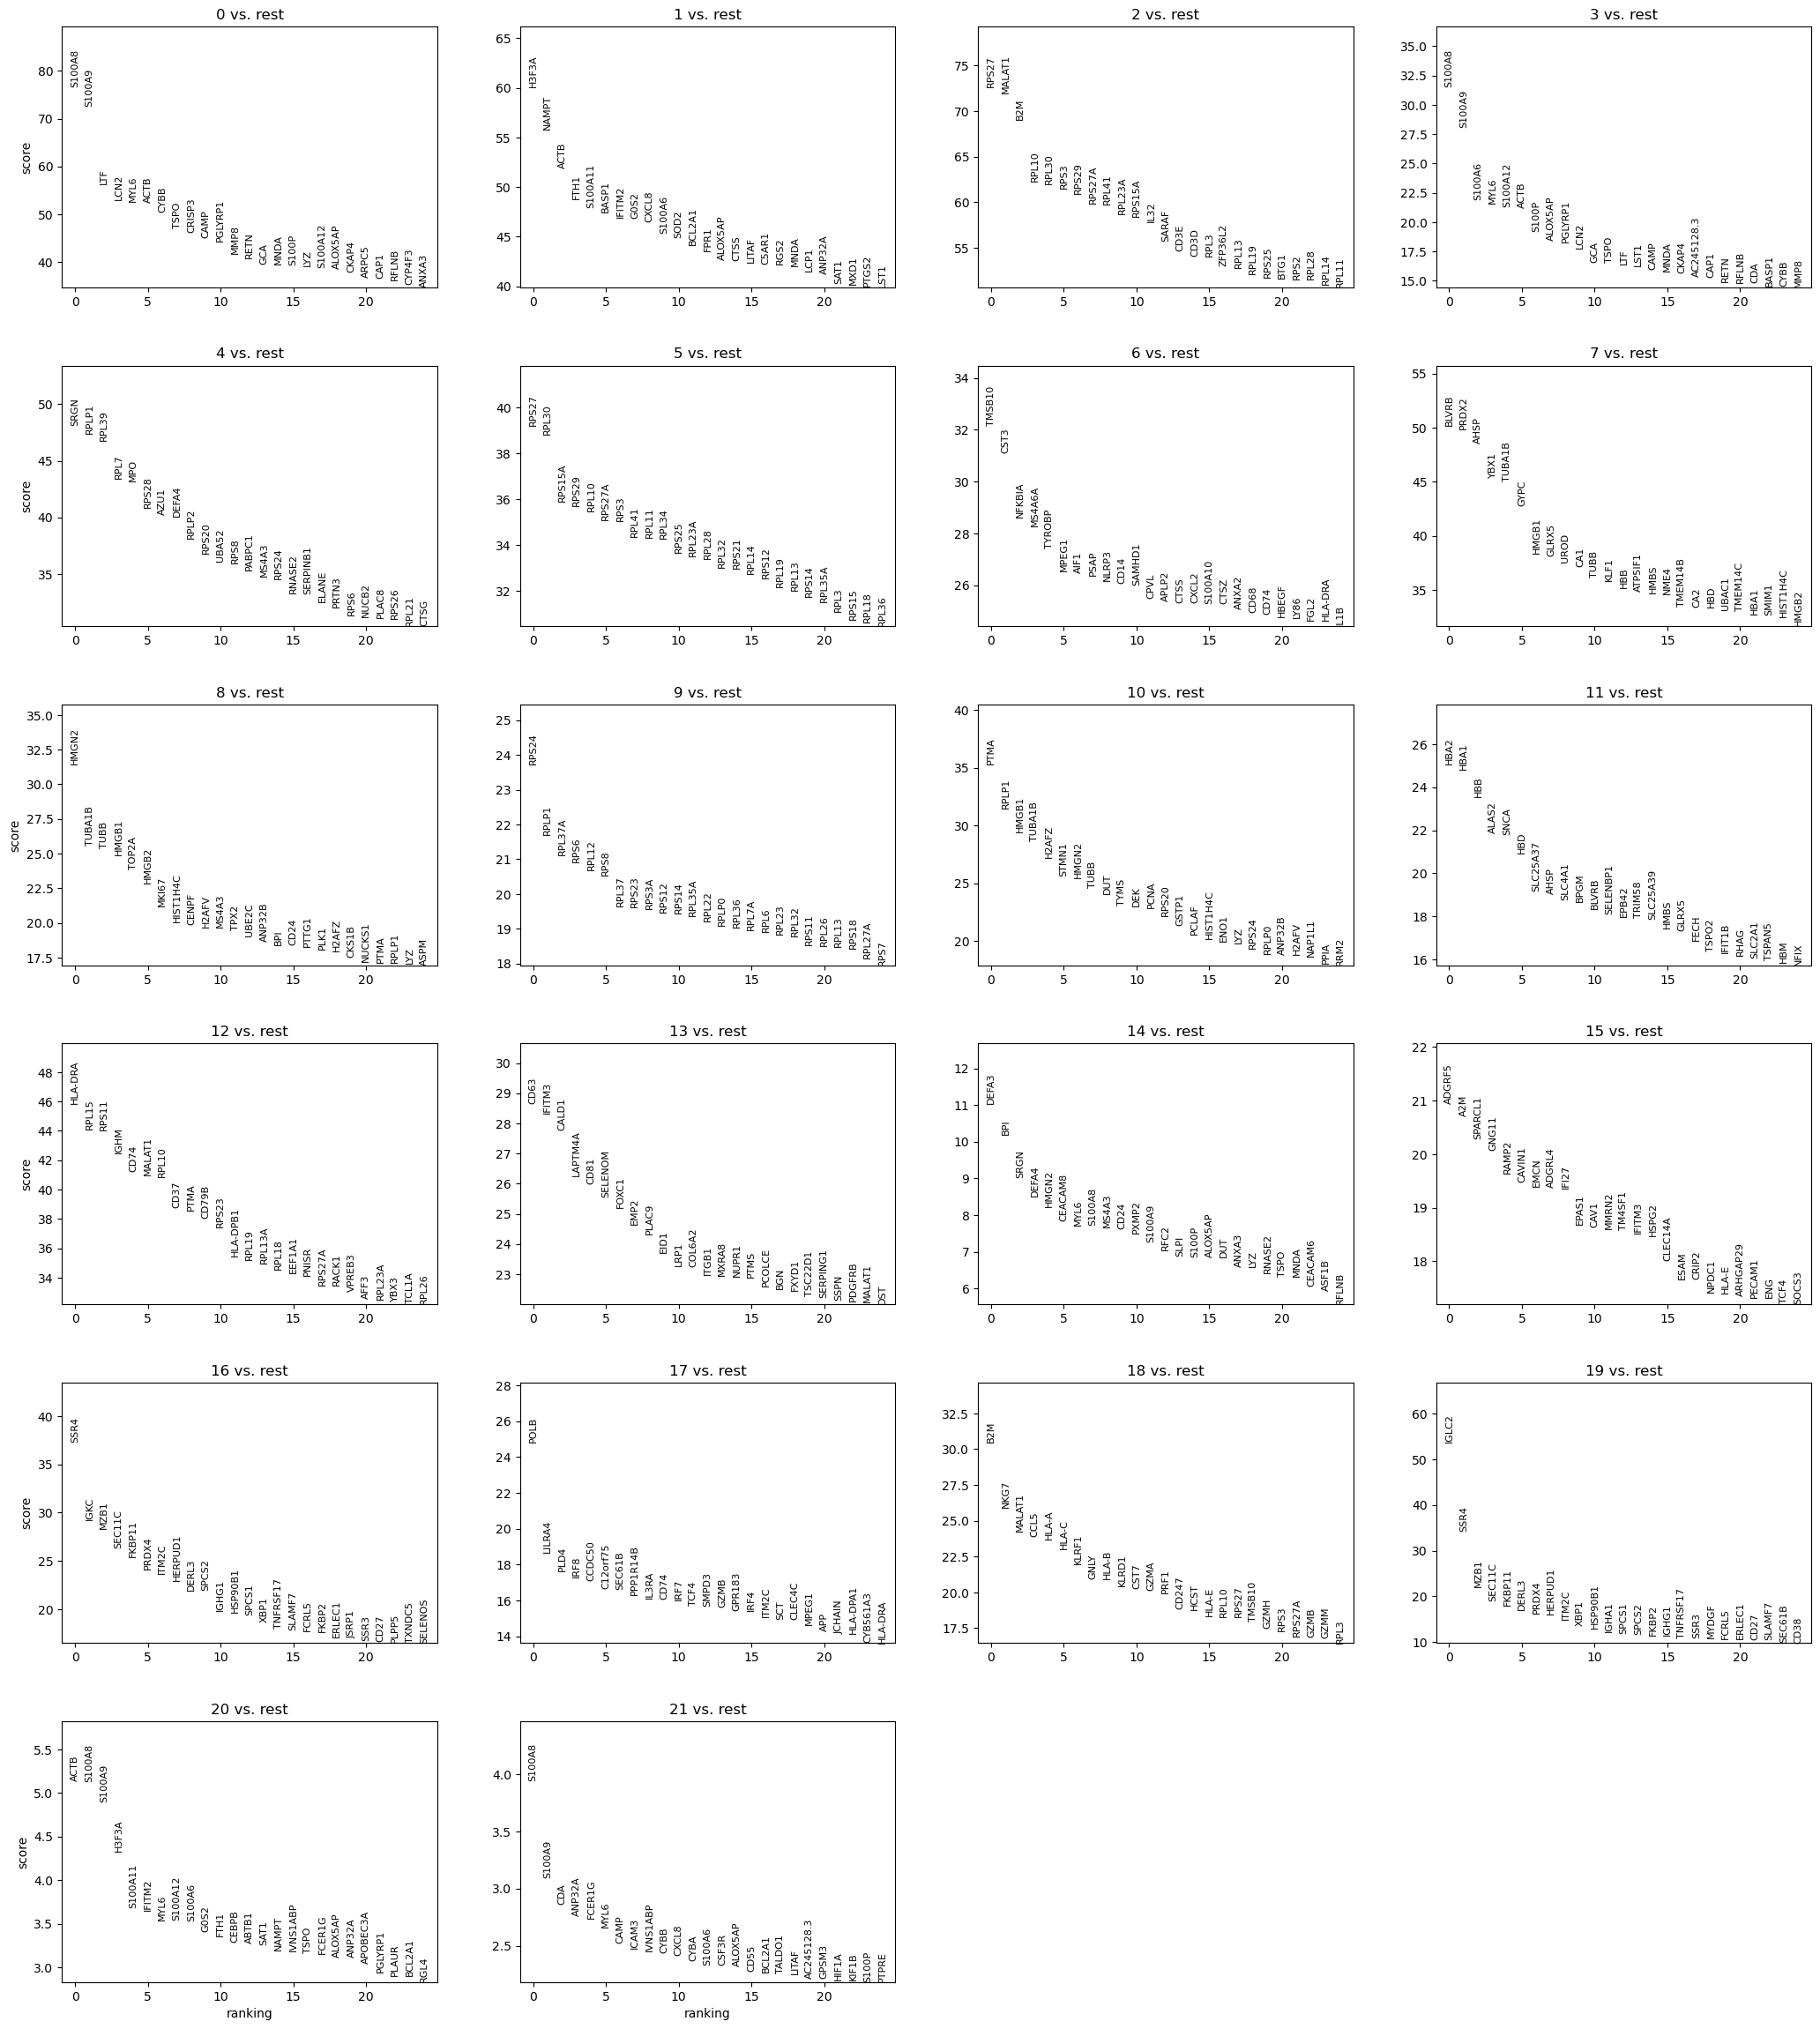

In [112]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [113]:
print((adata.uns['rank_genes_groups']['names'][10]))


('PGLYRP1', 'SOD2', 'RPS15A', 'GCA', 'UBA52', 'RPS25', 'SAMHD1', 'TUBB', 'MS4A3', 'RPS14', 'DEK', 'BLVRB', 'RPS23', 'LRP1', 'PXMP2', 'CAV1', 'IGHG1', 'IRF7', 'CST7', 'HSP90B1', 'FTH1', 'CXCL8')


In [114]:
# get list of differentially expressed genes
de_genes = adata.uns['rank_genes_groups']['names'][:1000]
gs = []
for i in de_genes:
    for j in i:
        gs.append(j)

# print(gs)

In [115]:
genes_list = ["PTH", "CYP27A1", "CYP2R1", "CYP27B1", "FGF23", "VDR", "GATA3", "CARS", "DGKD", "DGKH", "NADSYN1", "GC", "DHCR7",
             "TRPV5", "TRPV6", "ATP2B1", "SLC8A1"]

In [116]:

# filter genes that are known to be involved in calcium signaling
key_genes = [gene for gene in gs if gene in genes_list]
print(set(key_genes))

{'SLC8A1', 'DGKD', 'NADSYN1', 'VDR', 'DHCR7', 'GATA3', 'ATP2B1', 'DGKH', 'CYP27B1'}


SLC8A1
DHCR7
ATP2B1
GATA3
DGKD
DGKH
VDR
CYP27A1

>> Identified 

## Genes to be considered according to https://academic.oup.com/ndt/article/29/suppl_4/iv55/1908818:
startswith:
- PTH
- CYP27A1
- CYP2R1
- CYP27B1
- FGF23
- VDR
- GATA3
- CARS
- DGKD
- DGKH
- NADSYN1
- GC
- DHCR7
- 

Genes Not effecting according to the paper, but are related to calcium synthesis:
- TRPV5
- TRPV6
- ATP2B1
- SLC8A1